# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Поиск ближайших соседей

## Общая информация

Дата выдачи: 07.06.2021

Жёсткий дедлайн: 19.06.2021 05:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи

Задания сдаются через систему anytask. Посылка должна содержать:

* Ноутбук homework-practice-13-knn-Username.ipynb

Username — ваша фамилия на латинице.

---

# Вам нужно реализовать один из алгоритмов на выбор - LSH или NSW


В этом задании мы будем работать с датасетом [FashionMnist](https://github.com/zalandoresearch/fashion-mnist) изображений предметов одежды и обуви. В файле уже находится массив со 100 найденными соседями каждого тестового объекта по евклидовой метрике, однако мы для начала (чтобы реализовать метод случайных проекций) попробуем найти 100 ближайших соседей для каждого объекта по косинусной близости.

In [1]:
! wget -nc -q http://ann-benchmarks.com/fashion-mnist-784-euclidean.hdf5

In [2]:
import h5py


with h5py.File('fashion-mnist-784-euclidean.hdf5', 'r') as f:
    train = f['train'][()]
    test = f['test'][()]
    true_neighbors_eucl = f['neighbors'][()]

print(train.shape)
print(test.shape)
print(true_neighbors_eucl.shape)

(60000, 784)
(10000, 784)
(10000, 100)


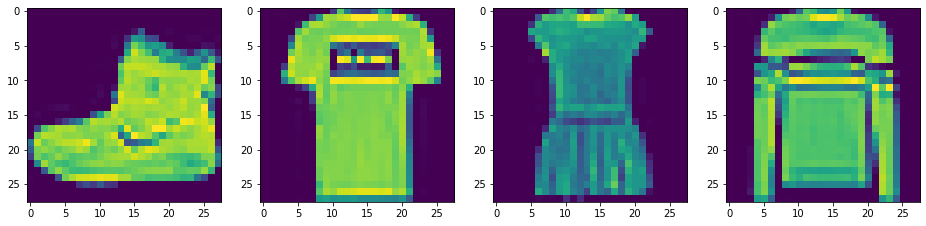

In [3]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.imshow(train[0].reshape(28, 28))

plt.subplot(142)
plt.imshow(train[1].reshape(28, 28))

plt.subplot(143)
plt.imshow(train[3].reshape(28, 28))

plt.subplot(144)
plt.imshow(train[5].reshape(28, 28))

plt.show()

В библиотеке `scikit-learn` есть модуль с алгоритмами поиска ближайших соседей, помогающий решать задачи классификации и регрессии. В этом задании, однако, нас будет интересовать не классификация, а качество и скорость решения непосредственно задачи поиска. Определим для этого две метрики:

* **Recall**: доля «настоящих соседей», которых нашёл алгоритм поиска. Пример: если вам необходимо найти 100 ближайших соседей, и из 100 возвращённых алгоритмом объектов 93 действительно находятся в множестве ближайших, то полнота равна 0.93.


* **Queries per second (QPS), также requests per second (RPS)**: число запросов, на которое алгоритм успевает ответить за одну секунду. Часто эту характеристику вычисляют как $\dfrac{num\_queries}{total\_time}$, где $num\_queries$ — общее число запросов, а $total\_time$ — суммарное время их выполнения; однако, так как некоторые реализации в задании умеют группировать запросы и выполнять несколько параллельно, мы будем осуществлять их по отдельности и усреднять величину $\dfrac{1}{request\_time}$.

Хотя в классе `NearestNeighbors` нет методов приближённого поиска ближайших соседей, мы воспользуемся им, чтобы найти 100 ближайших объектов по косинусной близости, сформировав таким образом правильные ответы для приближённых методов. Алгоритмы `kd_tree` и `ball_tree` в этом классе не поддерживают `metric=cosine`, поэтому распараллелим полный перебор:

In [4]:
from sklearn.neighbors import NearestNeighbors


sklearn_index = NearestNeighbors(
    n_neighbors=100,
    algorithm='brute',
    metric='cosine',
    n_jobs=-1
)

sklearn_index.fit(train)

true_neighbors_cosine = sklearn_index.kneighbors(
    test,
    n_neighbors=100,
    return_distance=False
)

In [5]:
from tqdm.auto import tqdm
from time import perf_counter
import numpy as np

def compute_recall_qps(query_func: callable, test_set: np.ndarray, true_neighbors: np.ndarray, **kwargs):
    """
    Given a function that returns a list of nearest neighbors, estimate its recall and speed.
    Args:
        query_func: function with signature (query, k_neighbors, **kwargs).
            Returns a list of k_neighbors approximate nearest neighbors for a query
        test_set: array with shape (num_objects, dim). Contains query vectors for recall evaluation
        true_neighbors: array of indices with shape (num_objects, num_neighbors). Contains ground truth data for
            recall evaluation. k_neighbors from query_func is inferred from its shape
        **kwargs: passed to query_func
    Returns:
        avg_recall: average recall of query_func over the test set
        qps: number of queries per second handled by query_func 
    """
    recalls = []
    query_times = []

    for sample, neighbors_for_sample in zip(test_set, tqdm(true_neighbors)):
        start = perf_counter()

        approx_neighbors = query_func(sample, k_neighbors=neighbors_for_sample.shape[0], **kwargs)

        query_times.append(1 / (perf_counter() - start))

        set_true = set(neighbors_for_sample.tolist())
        hits = sum(1 for neighbor in approx_neighbors if neighbor in set_true)

        recalls.append(hits / len(set_true))

    return np.mean(recalls), np.mean(query_times)

**Задание 1. (7 баллов)**

Реализуйте все методы класса `LSHIndex` или [`NSWIndex`](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059), а затем постройте индекс по датасету `FashionMNIST` и подсчитайте recall вашего решения. 

Чтобы для удобства вместо косинусной близости считать скалярное произведение, и обучающую, и тестовую части датасета можно нормировать заранее.

In [6]:
import numpy as np

In [7]:
np.linalg.norm(train, axis=1).reshape((-1, 1))

array([[3941.9375],
       [4135.156 ],
       [1727.5121],
       ...,
       [3748.563 ],
       [1610.87  ],
       [1483.911 ]], dtype=float32)

In [8]:
train /= np.linalg.norm(train, axis=1).reshape((-1, 1))
test /= np.linalg.norm(test, axis=1).reshape((-1, 1))

Получается, мы хотим найти 100 ближайших соседей для каждого наблюдения тестовой выборки, базируясь на данных из обучающей выборки. Для поиска соседей воспользуемся композициями хэш-функций.

In [10]:
# LSH


def compute_hashes(matrices, query):
    """
    Compute hash values for each hash table and a given vector.
    Args:
        matrices: np.array of shape (NUM_TABLES, NUM_BITS, dim), last axis represents
            random hyperplanes for each hash bit of each table
        query: vector to be hashed
    Returns:
        hashes: np.array of shape (NUM_TABLES, ), contains hash values for each table as unsigned integers
    """

    # YOUR CODE HERE
    # по аналогии с лекцией бинаризуем sign(x), где в качестве x используется умножение матрицы будущей композиции хэшей на хэшируемый вектор 
    binary_matrix = (np.sign(matrices@query)+1)*0.5
    
    # помимо бинарного вектора для расчёта хэшей полезно будет знать индекс каждого ненулевого значения функции
    indexes = np.arange(0, matrices.shape[1])+1

    return binary_matrix @ indexes


class LSHIndex:

    def __init__(self, vectors, projection_matrices):
        """
        Build the index and store vectors for efficient neighbors search.
        Args:
            vectors: Training data, np.array (num_vectors, dim). Each k-NN query looks for neighbors in this set
            projection_matrices: np.array of shape (NUM_TABLES, NUM_BITS, dim), last axis represents
                random hyperplanes for each hash bit of each table
        """

        # YOUR CODE HERE
        self.vectors = vectors
        self.matrices = projection_matrices

        # вспомогательный вектор для расчёта индексов при хэш-функциях
        binary_vec = ((np.sign(self.matrices @ self.vectors.T)+1)*0.5).T
        binary_vec = np.swapaxes(binary_vec, 1, 2)
        self.hash_vec = binary_vec @ (np.arange(0, self.matrices.shape[1])+1)

    def query(self, query, k_neighbors):
        """
        A helper function to perform a k-NN query.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
        Returns:
            neighbors: a list of indices in the dataset
                used to build the index. Vectors at these positions represent approximate k nearest neighbors of
                the query, indices do not need to be sorted by any property
        """
        hashes = compute_hashes(np.asarray(self.matrices), query)

        return self._search_neighbors(query, k_neighbors, hashes)

    def _search_neighbors(self, query, k_neighbors, hashes):
        """
        All the fun happens here. Given a sample, its hashes and the number  of neighbors, locate nearest neighbors
            wrt cosine similarity using the hash tables built during index construction.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            hashes: an array containing hash values of query for each hash table
        Returns:
            neighbors: a list of indices in the dataset
                used to build the index. Vectors at these positions represent approximate k nearest neighbors of
                the query, indices do not need to be sorted by any property
        """

        # YOUR CODE HERE
        # определение возможных соседей (мб сосед если хотя бы одно значение хэша совпало) 
        neighbors_potentionally = np.unique(np.where(hashes==self.hash_vec)[0])
        
        # расчёт расстояний
        dist = 1 - self.vectors[neighbors_potentionally] @ query
        
        return neighbors_potentionally[dist.argsort()[:k_neighbors]]

In [ ]:
#@title NSW не сделал (да и не надо было, у Глеба там столько проблем возникло)
# NSW


class NSWIndex:

    def __init__(self, vectors, num_neighbors, num_construction_runs):
        """
        Build the index and store vectors for efficient neighbors search.
        Args:
            vectors: Training data, np.array (num_vectors, dim). Each k-NN query looks for neighbors in this set
            num_neighbors: how many neighbors to look for during sequential insertion
            num_construction_runs: number of search attempts in k-NN search during construction
        """
        # YOUR CODE HERE

        raise NotImplementedError

    def query(self, query, k_neighbors, num_search_runs):
        """
        A helper function to perform a k-NN query. Used to ensure that _knn_search can be called with GIL lifted.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            num_search_runs: number of search attempts (parameter m in the NSW paper)
        Returns:
            neighbors: a list of indices in the dataset used to build the index. Vectors at these positions
            represent approximate k nearest neighbors of the query, indices do not need to be sorted
        """
        return self._knn_search(query, k_neighbors, num_search_runs)

    def _knn_search(self, query, k_neighbors, num_search_runs):
        """
        Run the NSW search algorithm in a constructed graph.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            num_search_runs: number of search attempts (parameter m in the NSW paper)
        Returns:
            neighbors: a list of indices in the dataset used to build the index. Vectors at these positions
            represent approximate k nearest neighbors of the query, indices do not need to be sorted
        """
        # YOUR CODE HERE

        raise NotImplementedError

Функции для подсчета нужных метрик

Попробуем посмотреть как хорошо написанный алгоритм справляется с задачей для поиска всех возможных соседей из тестовой выборки

In [11]:
mat = np.random.randn(100, 20, 784)
lsh = LSHIndex(train, mat)

Сразу заведём списочек, чтобы учитывать получившиеся результаты во втором задании

In [12]:
lsh_res = []

In [13]:
# YOUR CODE HERE

recall, qps = compute_recall_qps(lsh.query, test, true_neighbors_cosine)
lsh_res.append((recall, qps))
print(recall, qps)

assert recall >= 0.95

0.978193 11.247818552815842


In [14]:
mat = np.random.randn(5, 3, 784)
lsh = LSHIndex(train, mat)

In [15]:
recall, qps = compute_recall_qps(lsh.query, test, true_neighbors_cosine)
lsh_res.append((recall, qps))
print(recall, qps)
assert recall >= 0.95

0.9890950000000001 15.983628009552863


Прогнал несколько раз и заметил, что чем меньше хэш-функций берётся для каждой композиции (при одинаковом количестве векторов в композиции), тем дольше отрабатывает функция и тем выше точность. Наверное, это логично, учитывая то, что мы пытаемся ужать размерность пространства в этих функциях. 

При этом на большом количестве хэш-функций, вероятно, теряем какие-то важные признаки при запоминании обучающей выборки или, что более вероятно, в случае малой размерности хэш-функции вероятность попадания в массив потенциальных соседей ниже, из-за чего качество и увеличивается.

Надеюсь, не написал какую-нибудь лютую глупость...

Визуализируйте пример работы алгоритма: найдите 5 ближайших соседей для нескольких объектов тестовой выборки и покажите, каким изображениям они соответствуют (вместе с самим запросом).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


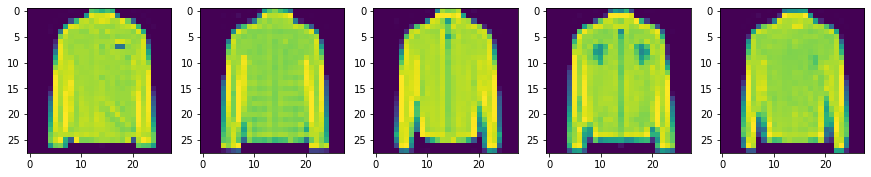

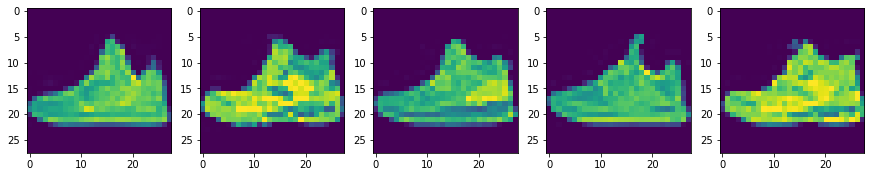

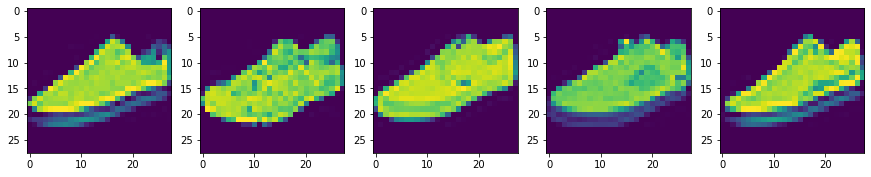

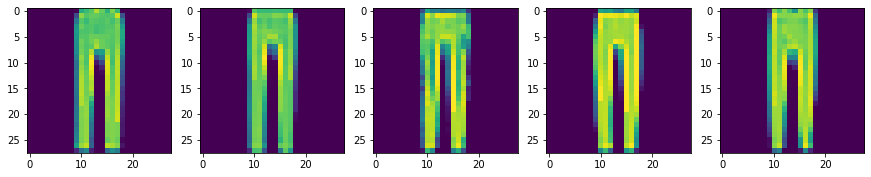

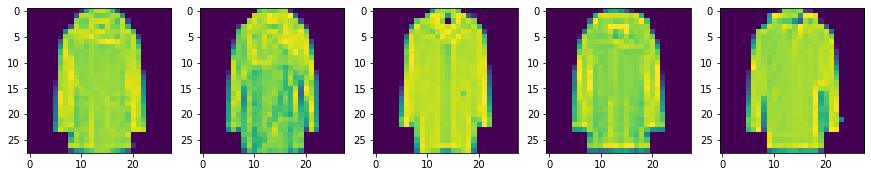

In [17]:
# YOUR CODE HERE
for i in np.random.choice(10000, 5):
    neighbors = lsh.query(test[i], 5)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(151)
    plt.imshow(test[i].reshape(28, 28))
    for j in range(5):
        plt.subplot(151+j)
        plt.imshow(train[neighbors[j]].reshape(28, 28))

    plt.show()

Обулись, оделись, всё похоже, ура!

**Задание 2. (3 балла)**

Исследуйте и покажите на графиках зависимость recall и QPS от размера хэша и числа хэш-таблиц в случае `LSH` или `num_construction_runs` и `num_search_runs` в случае NSW.

Сравните вашу реализацию с классом `sklearn.neighbors.NearestNeighbors`: так как для косинусной близости в этом классе поддерживается только `algorithm='brute'`, вы получите время работы точного поиска ближайших соседей. Для честности сравнения укажите в конструкторе метода `n_jobs` равным 1 и при замерах времени проводите поиск соседей для каждого объекта отдельно.

Отметьте соответствующую ему точку на графике recall-QPS, а затем с помощью перебора гиперпараметров постройте кривую в этих координатах для вашей реализации (нужно протестировать хотя бы 5 различных комбинаций). При построении можете вдохновляться графиками с сайта [ann-benchmarks](http://ann-benchmarks.com/):

![](http://ann-benchmarks.com/fashion-mnist-784-euclidean_100_euclidean.png)

In [18]:
# YOUR CODE HERE
for hash_number, hash_size in [(2, 10), (3, 8), (4, 6), (5, 8), (8, 10), (10, 20)]:
    projection_matrices = np.random.normal(size=(hash_number, hash_size, 784)) 
    lsh = LSHIndex(train, projection_matrices)
    recall, qps = compute_recall_qps(lsh.query, test, true_neighbors_cosine)
    lsh_res.append((recall, qps))

In [19]:
lsh_res

[(0.978193, 11.247818552815842),
 (0.9890950000000001, 15.983628009552863),
 (0.39818600000000004, 168.92603814791775),
 (0.698549, 65.674065406311),
 (0.8705230000000002, 33.48826304803011),
 (0.8596400000000002, 42.74809554918305),
 (0.8501080000000002, 39.56464811548536),
 (0.6492479999999999, 63.36626974385376)]

Отсортируем значения, чтобы на графике получилась красивая линия

In [21]:
lsh_res = np.array(sorted(lsh_res, key=lambda tup: tup[0]))

In [22]:
sklearn_index = NearestNeighbors(
    n_neighbors=100,
    algorithm='brute',
    metric='cosine',
    n_jobs=1
)

sklearn_index.fit(train)

recall_sklearn, qps_sklearn = compute_recall_qps(sklearn_index.kneighbors, 
                                       test, true_neighbors_cosine)

TypeError: ignored

In [23]:
sklearn_index.kneighbors()

(array([[0.04358137, 0.04673779, 0.04802597, ..., 0.07661867, 0.07663798,
         0.07664454],
        [0.03229034, 0.0326255 , 0.03354913, ..., 0.04584253, 0.04594183,
         0.04596686],
        [0.02789807, 0.0483799 , 0.05960333, ..., 0.09353495, 0.09362316,
         0.09367979],
        ...,
        [0.04119772, 0.04256654, 0.04335749, ..., 0.07443845, 0.07444847,
         0.07451069],
        [0.06255525, 0.0637126 , 0.06580472, ..., 0.10044348, 0.10052967,
         0.10071182],
        [0.1458795 , 0.17465979, 0.17688125, ..., 0.24219984, 0.24231362,
         0.24235404]], dtype=float32),
 array([[25719, 27655, 18078, ..., 14687, 31794,   594],
        [31949, 42564, 37550, ..., 15155, 36393, 57750],
        [54027, 53513,  1071, ..., 38150, 39160,   160],
        ...,
        [22416, 45348, 26586, ..., 32693, 28147, 20074],
        [43681,  6956, 54322, ..., 57628,  2437, 44915],
        [40600, 29249, 51258, ..., 22636, 23055, 57597]]))

Видимо, исходная прописанная в шаблоне функция составлена чисто под нашу реализацию LSH, надо чуть-чуть переписать её

In [24]:
def compute_recall_qps(query_func: callable, test_set: np.ndarray, true_neighbors: np.ndarray, **kwargs):
    """
    Given a function that returns a list of nearest neighbors, estimate its recall and speed.
    Args:
        query_func: function with signature (query, k_neighbors, **kwargs).
            Returns a list of k_neighbors approximate nearest neighbors for a query
        test_set: array with shape (num_objects, dim). Contains query vectors for recall evaluation
        true_neighbors: array of indices with shape (num_objects, num_neighbors). Contains ground truth data for
            recall evaluation. k_neighbors from query_func is inferred from its shape
        **kwargs: passed to query_func
    Returns:
        avg_recall: average recall of query_func over the test set
        qps: number of queries per second handled by query_func 
    """
    recalls = []
    query_times = []

    for sample, neighbors_for_sample in zip(test_set, tqdm(true_neighbors)):
        start = perf_counter()
        
        approx_neighbors = sklearn_index.kneighbors(sample.reshape(1,-1), n_neighbors=100, return_distance=False)[0]

        query_times.append(1 / (perf_counter() - start))

        set_true = set(neighbors_for_sample.tolist())
        hits = sum(1 for neighbor in approx_neighbors if neighbor in set_true)

        recalls.append(hits / len(set_true))

    return np.mean(recalls), np.mean(query_times)

In [25]:
sklearn_index = NearestNeighbors(
    n_neighbors=100,
    algorithm='brute',
    metric='cosine',
    n_jobs=1
)

sklearn_index.fit(train)

recall_sklearn, qps_sklearn = compute_recall_qps(sklearn_index.kneighbors, 
                                       test, true_neighbors_cosine)

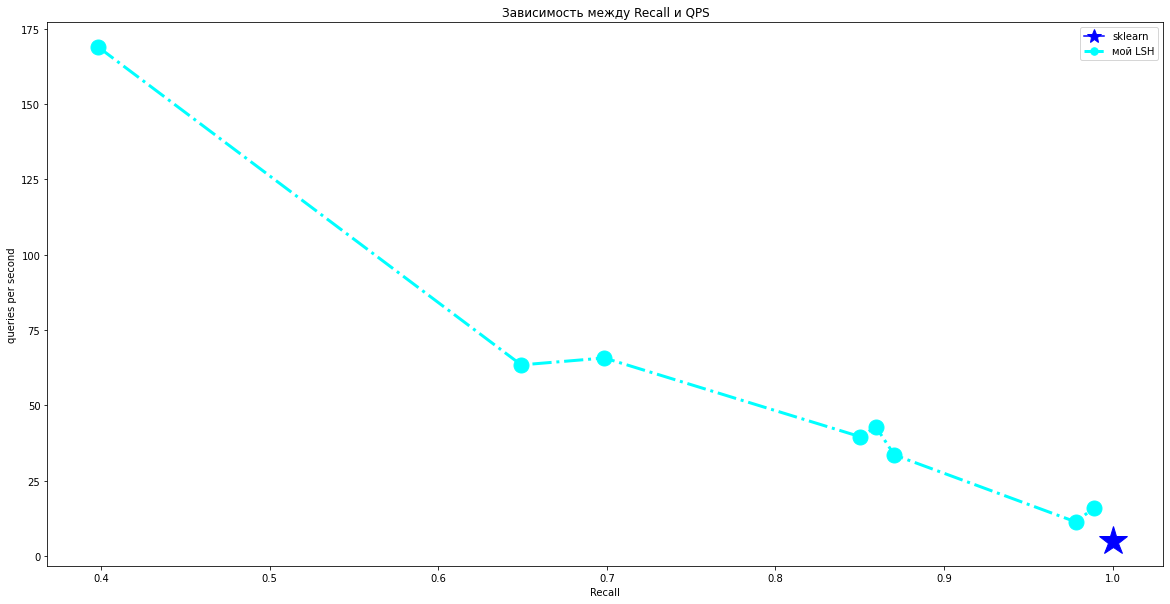

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(recall_sklearn, qps_sklearn, color='b', marker='*', markersize=30, label='sklearn')
plt.plot(lsh_res[:, 0], lsh_res[:, 1], color='cyan', marker='.', linestyle='-.', markersize=30, linewidth=3, label='мой LSH')
plt.xlabel('Recall')
plt.ylabel('queries per second')
plt.title('Зависимость между Recall и QPS')
plt.legend(markerscale=0.5)
plt.show()

Видим, что при качественном подборе гиперпараметров размера композции хэш-функции и длины самих хэш-функций можно получить значения, приводящие к нелинейному строению представленной ломанной LSH. И кажется, что при композиции хэш-функций размерностью 5 с 3 аргументами в хэш-функции у нас получается наилучший баланс качества и скорости работы (в 3 раза быстрее обычного KNN, по качеству почти никак не уступает). Если нам важно получить достойный результат как можно быстрее, LSH явно превсходит обычный KNN.

**Бонус. (0.01 балла)**

Приложите свой любимый рецепт (необязательно завтрака) и расскажите, почему он вам так нравится.

Мог бы привести легендарный рецепт плова из мемов 10-ых годов, но лучше буду соблюдать академическую этику и приведу по-настоящему любимый рецепт. Его электронный аналог [тут](https://www.iamcook.ru/showrecipe/10703).


1.   Берём 1-2кг картошки, 2 луковицы, покупаем в ближайшем продуктовом филе куриной грудки.
2.   Режем филе на небольшие полоски, чтобы быстрее прожарились, кладём на разогретую сковороду и солим плюс обильно перчим
3. Пока курица жарится, включаем режим турбо, чтобы помыть и почистить картофель
4. Нарезаем картошку на небольшие ломтики, предварительно разрезав каждую напополам. Надеюсь, успеваем кинуть на сковороду пока курица не превратилась в угли
5. Чтобы ничего не сгорело, лучше вообще делать это на разных сковородках
6. Жарим и курицу, и картошку до золотистых корочек (минут 25 курицу, минут 20-25 картошку)
7. Когда картошка вроде бы уже не прям сырая (можно проверить вилкой или ножом), надо посолить её и добавить предварительно нарезанный лук (чтобы не щипало глазки, я обычно мою его под холодной водой до нарезки). И да, лук не зелёный, а нормальный
8. Когда всё приготовилось, кладём небольшой кусочек масла на картошку и кушаем
9. При желании можно добавить к столу маринованные огурцы, грибы или помидоры
10. Не переедаем, чтобы потом не болел живот, остатки складываем в пластиковую форму для хранения и после охлаждения кладём в холодильник.

Почему нравится? Картошка и курица достаточно дешёвые, их несложно найти в любом продуктовом, для приготовления не надо выдумывать вообще ничего сложного, тупо постоять 10 минут над чисткой картофеля и 30 минут над плитой. Параллельно можно послушать лекцию Евгения Андреевича про LSH.

P.s. Не понимаю, как любимый рецепт связан с темой этой домашки, но ладно



